In [3]:
%load_ext autoreload
%autoreload 2

# Analysis of sequence-level mutations

For DPhil thesis.

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import partial

from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from common import set_theme

set_theme(style='whitegrid')
PALETTE = 'viridis'

top_write_dir = os.path.join('data', '25_mutations')

In [5]:
fn = '../data/raw/summarise_simulation/2024_11_27_145142/tabulated_mutation_info.csv'
data = pd.read_csv(fn)

In [ ]:
data.rename(columns={'mutation_num': 'N mutations'}, inplace=True)
data['Log sensitivity'] = np.log10(data['sensitivity'])
data['Log precision'] = np.log10(data['precision'])
data['adaptation'] = calculate_adaptation(np.array(data['sensitivity']), np.array(data['precision']), alpha=2)


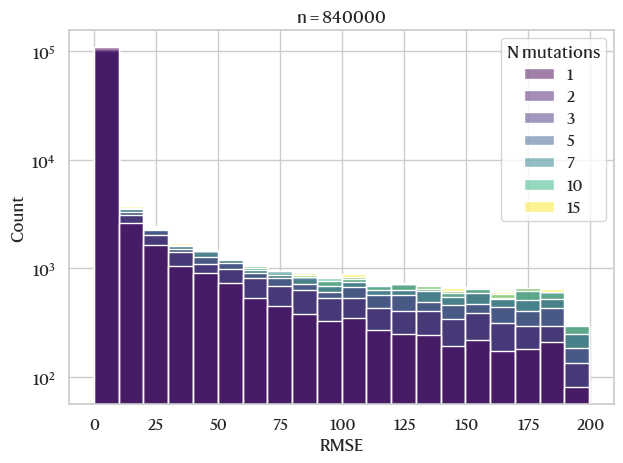

In [40]:
filt_samp = (data['sample_name'] == 'RNA_2')
filt_m = (data['N mutations'] > 0)
filt = filt_m & filt_samp & (
    data['RMSE'].notnull()) & (data['RMSE'] < np.inf)
g = sns.histplot(data[filt], x='RMSE', hue='N mutations',
             palette=PALETTE,
             bins=20) #, fill=False, element='step')
plt.yscale('log')
plt.title(f'n = {len(data[filt])}')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'mutation_rmse_histogram.png'), dpi=300, transparent=True)

In [41]:
get_true_interaction_cols2 = partial(get_true_interaction_cols, remove_symmetrical=True, num_species=data['sample_name'].nunique())

datam = pd.DataFrame()
k = 'energies'
cols_e = get_true_interaction_cols2(data, k)
datam[f'{k}_diffs'] = data[filt_samp].groupby(['circuit_name'])[cols_e].apply(
    lambda x: x - x.iloc[0]).melt(value_vars=cols_e, 
                                  var_name='idx', value_name=f'{k}_diffs')[f'{k}_diffs']
datam['N mutations'] = data[filt_samp].melt(id_vars = 'N mutations',value_vars=cols_e, 
                                  var_name='idx', value_name=f'{k}_diffs')['N mutations']

In [56]:
for k in ['Log sensitivity', 'Log precision', 'adaptation']:
    # data[f'{k} diffs'] = data.groupby(['circuit_name', 'sample_name'])[k].apply(lambda x: x - x.iloc[0]).reset_index()[k]
    data[f'{k} diffs'] = data.groupby(['circuit_name', 'sample_name'])[k].apply(lambda x: x - x.iloc[0]).reset_index().sort_values('level_2').reset_index()[k]

In [57]:
data.head()

,circuit_name,mutation_name,N mutations,mutation_type,mutation_positions,path_to_template_circuit,index,sample_num,name,interacting,...,precision,sensitivity,sample_name,Log sensitivity,precision diffs,Log precision,adaptation,Log sensitivity diffs,Log precision diffs,adaptation diffs
0,toy_mRNA_circuit_0,ref_circuit,0,[],[],./data/ensemble_mutation_effect_analysis/2024_...,0.0,9.0,toy_mRNA_circuit_0,[[0 1]],...,1.110351,1.000000,RNA_0,0.000000,0.000000,0.045460,846.429810,0.000000,0.000000,0.00000
1,toy_mRNA_circuit_0,ref_circuit,0,[],[],./data/ensemble_mutation_effect_analysis/2024_...,0.0,9.0,toy_mRNA_circuit_0,[[0 1]],...,10.266712,0.097402,RNA_1,-1.011431,0.108259,1.011431,829.532410,0.000000,0.000000,0.00000
2,toy_mRNA_circuit_0,ref_circuit,0,[],[],./data/ensemble_mutation_effect_analysis/2024_...,0.0,9.0,toy_mRNA_circuit_0,[[0 1]],...,4182.322300,0.000239,RNA_2,-3.621418,0.033724,3.621417,759.327637,0.000000,0.000000,0.00000
3,toy_mRNA_circuit_0,RNA_0_m1-0,1,[3],[18],./data/ensemble_mutation_effect_analysis/2024_...,0.0,9.0,toy_mRNA_circuit_0,[[0 1]],...,1.218610,1.000000,RNA_0,0.000000,-0.090828,0.085865,847.030640,0.000000,0.040405,0.60083
4,toy_mRNA_circuit_0,RNA_0_m1-0,1,[3],[18],./data/ensemble_mutation_effect_analysis/2024_...,0.0,9.0,toy_mRNA_circuit_0,[[0 1]],...,5.625166,0.177773,RNA_1,-0.750135,-0.090828,0.750135,834.310120,0.261296,-0.261296,4.77771


n = 5000 reference circuits


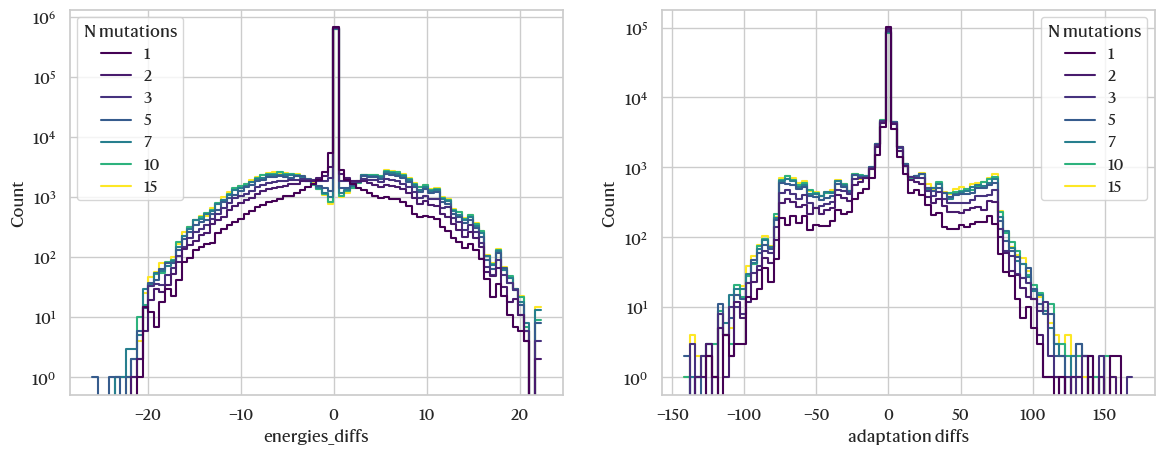

In [59]:
# plt.figure(figsize=(7,5))
fig, axs = plt.subplots(1, 2, figsize=(14,5))
sns.histplot(datam[datam['N mutations'] > 0], x=f'energies_diffs', hue='N mutations',
             palette=PALETTE, bins=80, fill=False, element='step', ax=axs[0])
axs[0].set_yscale('log')

sns.histplot(data[filt_m & filt_samp], x=f'adaptation diffs', hue='N mutations',
# sns.histplot(data[filt_m & filt_samp], x=f'Log sensitivity diffs', hue='N mutations',
             palette=PALETTE, bins=80, fill=False, element='step', ax=axs[1])
axs[1].set_yscale('log')
print(f'n = {data["circuit_name"].nunique()} reference circuits')

In [86]:
# data['circuit_idx'] = 
data['circuit_idx'] = 0
for s in data['sample_name'].unique():
    d = dict(data[(data['N mutations'] == 0) & (data['sample_name'] == s)].sort_values('adaptation').reset_index(
        ).rename(columns={'level_0': 'idx'}).reset_index()[['circuit_name', 'level_0']].values.tolist()) #.reset_index().groupby('circuit_name').ngroup()
    data.loc[data['sample_name'] == s, 'circuit_idx'] = data[data['sample_name'] == s]['circuit_name'].apply(lambda x: d[x])

<Axes: xlabel='circuit_idx', ylabel='adaptation'>

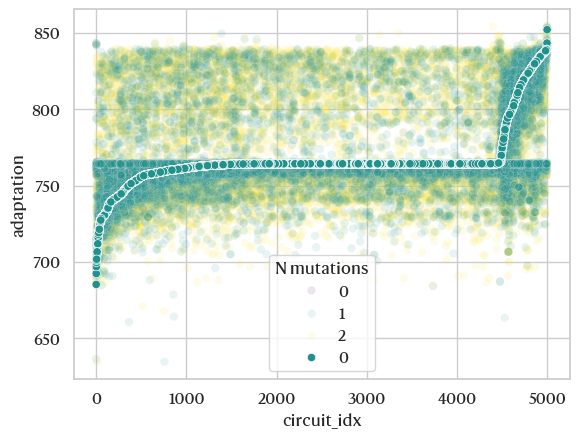

In [98]:
sns.scatterplot(data[(data['sample_name'] == 'RNA_2') & (data['N mutations'] < 3)].sort_values('N mutations', ascending=False),
                x='circuit_idx', y='adaptation', hue='N mutations', palette=PALETTE, alpha=0.1)
sns.scatterplot(data[(data['sample_name'] == 'RNA_2') & (data['N mutations'] == 0)].sort_values('N mutations', ascending=False),
                x='circuit_idx', y='adaptation', hue='N mutations', palette=PALETTE)